In [1]:
#read csv file in a dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

In [33]:
df = pd.read_csv(r'C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\IME Course\\SMA - II\\train.csv')

In [34]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [35]:
#drop id coloumn
df.drop('id', axis=1, inplace=True)

# Shape

In [6]:
df.shape

(20800, 4)

In [14]:
# find the missing values
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

# Missing Value Count

In [143]:
# 9. Verify Missing Values After Handling
def summarize_missing(data, dataset_name):
    print(f"\nMissing Values in {dataset_name}:")
    missing_counts = data.isnull().sum()
    missing_percent = (data.isnull().mean() * 100).round(2)
    missing_summary = pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing Count', 'Missing Percentage'])
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    
    if missing_summary.empty:
        print("No missing values.\n")
    else:
        print(missing_summary.sort_values(by='Missing Percentage', ascending=False), "\n")

summarize_missing(df, "Entire Dataset")



Missing Values in Entire Dataset:
        Missing Count  Missing Percentage
author           1957                9.41
title             558                2.68
text               39                0.19 



In [38]:
#calculate the number of 1 and 0 in the target variable
df['label'].value_counts()

label
1    10413
0    10387
Name: count, dtype: int64

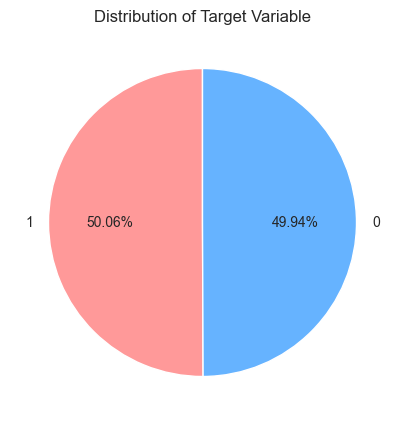

In [42]:
#draw distribution of target variable label using pie chart
plt.figure(figsize=(5, 5))
df['label'].value_counts().plot.pie(autopct='%1.2f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Target Variable')
plt.ylabel('')
plt.show()



In [9]:
df[df['title'] == ''].shape

(0, 4)

In [200]:
def fill_missing_titles(row):
    if pd.isnull(row['title']):
        return "Election News Related to Trump and Clinton" if row['label'] == 1 else "New York Time Briefing"
    return row['title']

df['title'] = df.apply(fill_missing_titles, axis=1)


In [205]:
#find the most frequent author
df['author'].value_counts()

author
Pam Key                                      243
admin                                        193
Jerome Hudson                                166
Charlie Spiering                             141
John Hayward                                 140
                                            ... 
Jeremy R. Hammond                              1
Vic Bishop                                     1
Douglas Martin                                 1
Najim Rahim and Fahim Abed                     1
Michael J. de la Merced and Rachel Abrams      1
Name: count, Length: 4201, dtype: int64

# Data Preprocessing

In [36]:
# Compute token counts
df['title_token_count'] = df['title'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)
df['author_token_count'] = df['author'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)
df['text_token_count'] = df['text'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)

## Handling Missing Values

### Text

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import nltk
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

# Identify missing 'text' entries
missing_text = df['text'].isnull() | (df['text'].str.strip() == '')
print(f"Number of missing 'text' entries: {missing_text.sum()}")

# Combine 'title' and 'author' for similarity features
df['combined_features'] = df['title'].fillna('') + ' ' + df['author'].fillna('')

# Vectorize combined features
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_features'])

# Scale numerical token counts
scaler = StandardScaler()
token_counts_scaled = scaler.fit_transform(df[['title_token_count', 'author_token_count']])

# Combine TF-IDF and token counts
X = hstack([tfidf_matrix, token_counts_scaled])

# Initialize and fit KNN
knn_text = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_text.fit(X)

# Define imputation function
def weighted_impute_text(row, df, knn):
    if pd.notnull(row['text']) and row['text'].strip() != '':
        return row['text']
    else:
        combined = row['combined_features']
        combined_vec = tfidf_vectorizer.transform([combined])
        token_counts = scaler.transform([[row['title_token_count'], row['author_token_count']]])
        X_current = hstack([combined_vec, token_counts])
        
        distances, indices = knn.kneighbors(X_current, n_neighbors=5)
        neighbor_texts = df.iloc[indices[0]]['text'].dropna()
        neighbor_distances = distances[0]
        
        if len(neighbor_texts) == 0:
            return "Missing Text"
        else:
            # Normalize distances to weights
            weights = 1 / (neighbor_distances + 1e-5)  # Add small value to avoid division by zero
            weights = weights / weights.sum()
            
            # For simplicity, concatenate texts weighted by similarity
            weighted_text = ' '.join([txt for txt in neighbor_texts])
            return weighted_text

# Apply weighted imputation
df['text_imputed'] = df.apply(lambda row: weighted_impute_text(row, df, knn_text), axis=1)

# Verify imputation
print(f"Missing 'text' before imputation: {missing_text.sum()}")
missing_imputed = df['text_imputed'].isnull() | (df['text_imputed'].str.strip() == '')
print(f"Missing 'text' after imputation: {missing_imputed.sum()}")

# Replace original 'text' with 'text_imputed'
df['text'] = df['text_imputed']
# Drop the 'text_imputed' column if it's no longer needed
df.drop('text_imputed', axis=1, inplace=True)


Number of missing 'text' entries: 116
Missing 'text' before imputation: 116
Missing 'text' after imputation: 3


In [ ]:
missing_text = df['text'].isnull() | (df['text'].str.strip() == '')
print(f"Number of missing 'text' entries: {missing_text.sum()}")

Number of missing 'text' entries: 3


In [7]:
df.head()

,title,author,text,label,title_token_count,author_token_count,text_token_count,combined_features
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,19,2,943,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,11,3,822,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7,1,1454,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,10,2,612,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,14,2,177,Iranian woman jailed for fictional unpublished...


### Author

In [7]:
# Identify missing 'author' entries
missing_author = df['author'].isnull() | (df['author'].str.strip() == '')
print(f"Number of missing 'author' entries: {missing_author.sum()}")

# Feature Engineering for 'author' imputation
# Combine 'title' and 'text' for similarity features
df['combined_features_author'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Vectorize combined features using TF-IDF
tfidf_author_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
tfidf_author_matrix = tfidf_author_vectorizer.fit_transform(df['combined_features_author'])

# Scale numerical token counts
scaler_author = StandardScaler()
token_counts_author_scaled = scaler_author.fit_transform(df[['title_token_count', 'text_token_count']])

# Combine TF-IDF and token counts
X_author = hstack([tfidf_author_matrix, token_counts_author_scaled])

# Initialize and fit KNN on non-missing 'author' entries
knn_author = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_author.fit(X_author)

# Define weighted imputation function for 'author'
def weighted_impute_author(row, knn, vectorizer, scaler):
    if pd.notnull(row['author']) and row['author'].strip() != '':
        return row['author']
    else:
        combined = row['combined_features_author']
        combined_vec = vectorizer.transform([combined])
        token_counts = scaler.transform([[row['title_token_count'], row['text_token_count']]])
        X_current = hstack([combined_vec, token_counts])
        
        # Find KNN neighbors
        distances, indices = knn.kneighbors(X_current, n_neighbors=5)
        neighbor_authors = df.iloc[indices[0]]['author'].dropna()
        neighbor_distances = distances[0]
        
        if neighbor_authors.empty:
            return "Unknown Author"
        else:
            # Compute weights based on distances (closer neighbors have higher weights)
            weights = 1 / (neighbor_distances + 1e-5)  # Add small value to avoid division by zero
            weights = weights / weights.sum()  # Normalize weights
            
            # Aggregate weights for each author
            author_weights = {}
            for author, weight in zip(neighbor_authors, weights):
                author_weights[author] = author_weights.get(author, 0) + weight
            
            # Select the author with the highest total weight
            imputed_author = max(author_weights, key=author_weights.get)
            return imputed_author

# Apply weighted imputation for 'author'
df['author_imputed'] = df.apply(
    lambda row: weighted_impute_author(row, knn_author, tfidf_author_vectorizer, scaler_author),
    axis=1
)

# Verify imputation
print(f"Missing 'author' before imputation: {missing_author.sum()}")
missing_imputed_author = df['author_imputed'].isnull() | (df['author_imputed'].str.strip() == '')
print(f"Missing 'author' after imputation: {missing_imputed_author.sum()}")

# Optional: Replace original 'author' with imputed values
df['author'] = df['author_imputed']
df.drop('author_imputed', axis=1, inplace=True)

Number of missing 'author' entries: 1957
Missing 'author' before imputation: 1957
Missing 'author' after imputation: 0


### Title

In [38]:
# Identify missing 'author' entries
missing_title = df['title'].isnull() | (df['title'].str.strip() == '')
print(f"Number of missing 'author' entries: {missing_title.sum()}")

# Combine 'author' and 'text' for similarity features
df['combined_features_title'] = df['author'].fillna('') + ' ' + df['text'].fillna('')

# Vectorize combined features using TF-IDF
tfidf_title_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
tfidf_title_matrix = tfidf_title_vectorizer.fit_transform(df['combined_features_title'])

# Scale numerical token counts
scaler_title = StandardScaler()
token_counts_title_scaled = scaler_title.fit_transform(df[['author_token_count', 'text_token_count']])

# Combine TF-IDF and token counts
X_title = hstack([tfidf_title_matrix, token_counts_title_scaled])

# Initialize and fit KNN on non-missing 'Title' entries
knn_title = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_title.fit(X_title)

# Define weighted imputation function for 'Title'
def weighted_impute_title(row, knn, vectorizer, scaler):
    if pd.notnull(row['title']) and row['title'].strip() != '':
        return row['title']
    else:
        # Vectorize the current row's features
        combined = row['combined_features_title']
        combined_vec = vectorizer.transform([combined])
        token_counts = scaler.transform([[row['title_token_count'], row['text_token_count']]])
        X_current = hstack([combined_vec, token_counts])
        
        # Find KNN neighbors
        distances, indices = knn.kneighbors(X_current, n_neighbors=5)
        neighbor_titles = df.iloc[indices[0]]['title'].dropna()
        neighbor_distances = distances[0]
        
        if neighbor_titles.empty:
            return "Unknown Title"
        else:
            # Compute weights based on distances (closer neighbors have higher weights)
            weights = 1 / (neighbor_distances + 1e-5)  # Add small value to avoid division by zero
            weights = weights / weights.sum()  # Normalize weights
            
            # Aggregate weights for each title
            title_weights = {}
            for title, weight in zip(neighbor_titles, weights):
                title_weights[title] = title_weights.get(title, 0) + weight
            
            # Select the title with the highest total weight
            imputed_title = max(title_weights, key=title_weights.get)
            return imputed_title

# Apply weighted imputation for 'Title'
df['title_imputed'] = df.apply(
    lambda row: weighted_impute_title(row, knn_title, tfidf_title_vectorizer, scaler_title),
    axis=1
)

missing_imputed_title = df['title_imputed'].isnull() | (df['title_imputed'].str.strip() == '')
print(f"Missing 'Title' after imputation: {missing_imputed_title.sum()}")

# Optional: Replace original 'Title' with imputed values
df['title'] = df['title_imputed']
df.drop('title_imputed', axis=1, inplace=True)


Number of missing 'author' entries: 558
Missing 'Title' after imputation: 0


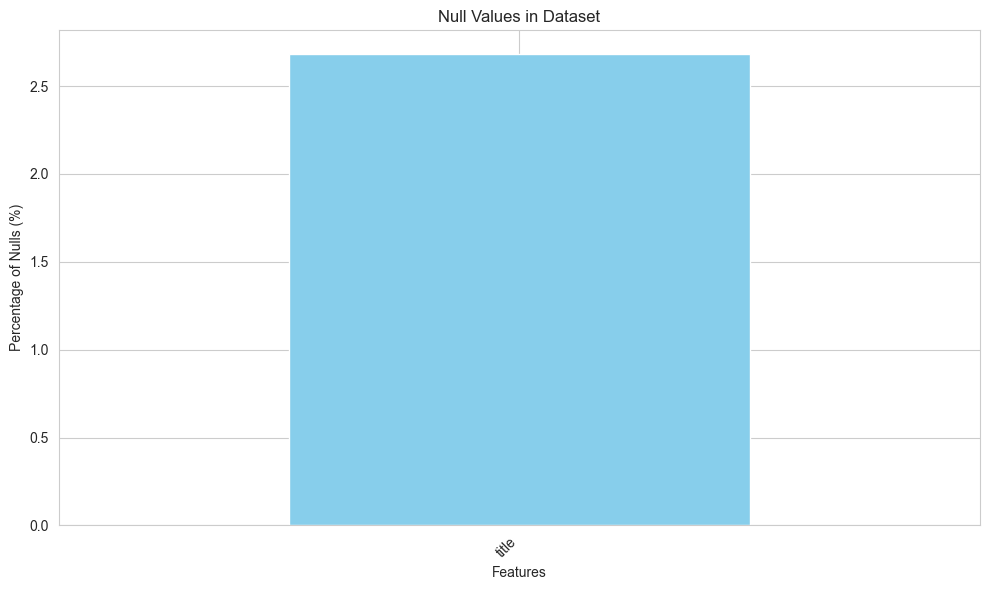

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_null_values_simple(data):
    null_percent = data.isnull().mean() * 100
    null_percent = null_percent[null_percent > 0]
    
    if null_percent.empty:
        print("No null values to plot.")
        return
    
    plt.figure(figsize=(10, 6))
    null_percent.plot(kind='bar', color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Percentage of Nulls (%)')
    plt.title('Null Values in Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the simplified function
plot_null_values_simple(df)

# EDA

## Null value distribtion

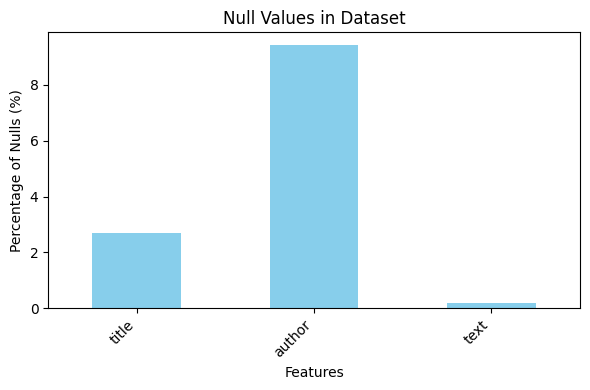

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_null_values_simple(data):
    null_percent = data.isnull().mean() * 100
    null_percent = null_percent[null_percent > 0]
    
    if null_percent.empty:
        print("No null values to plot.")
        return
    
    plt.figure(figsize=(6, 4))
    null_percent.plot(kind='bar', color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Percentage of Nulls (%)')
    plt.title('Null Values in Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the simplified function
plot_null_values_simple(df)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20800 non-null  object
 1   author  18843 non-null  object
 2   text    20800 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.1+ KB


## label distribution

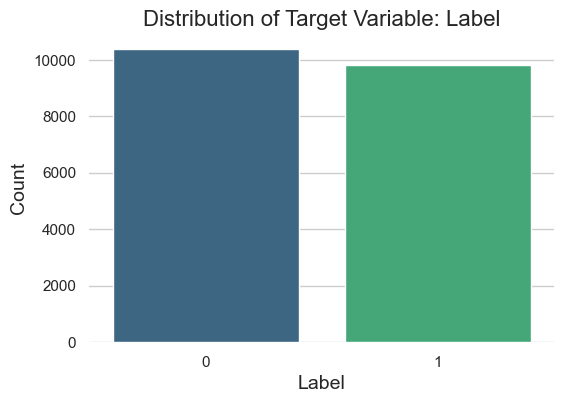

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for better aesthetics
sns.set(style="whitegrid")

# Create the count plot with `hue` assigned and legend disabled
plt.figure(figsize=(6, 4))
sns.countplot(x='label', hue='label', data=df, palette='viridis', legend=False)

# Add title and labels
plt.title('Distribution of Target Variable: Label', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Optional: Remove unnecessary spines for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()

In [9]:
# Convert 'title' and 'text' columns to string type to handle non-string entries
df['title'] = df['title'].astype(str)
df['text'] = df['text'].astype(str)
df['author'] = df['author'].astype(str)

## Number of Tokens in the Title, Text and Author Columns

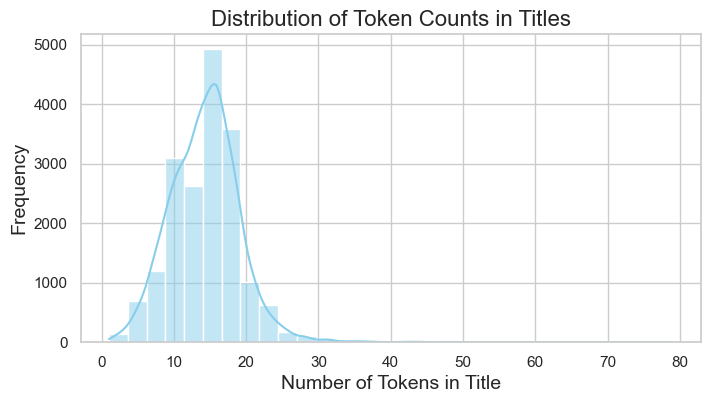

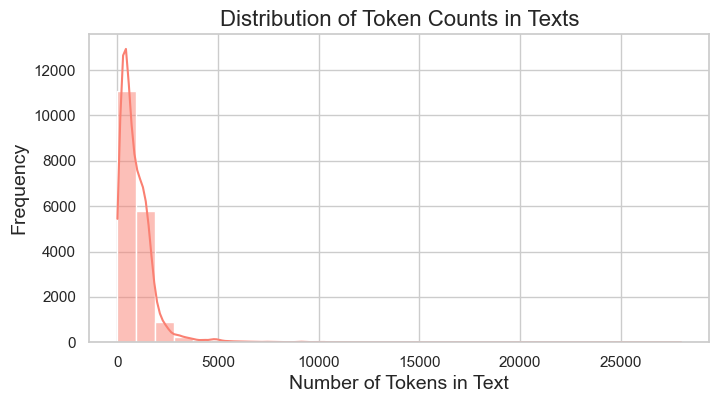

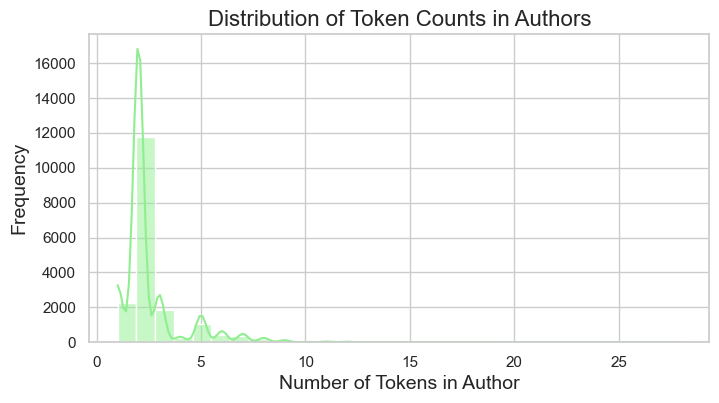

In [ ]:


# Define a function to count tokens using word_tokenize
def count_tokens(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return len(tokens)

# Apply the token count function to 'title' and 'text' columns
df['title_token_count'] = df['title'].apply(count_tokens)
df['text_token_count'] = df['text'].apply(count_tokens)
df['author_token_count'] = df['author'].apply(count_tokens)

sns.set(style="whitegrid")

# Plot histogram for Title Token Counts
plt.figure(figsize=(8, 4))
sns.histplot(df['title_token_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Token Counts in Titles', fontsize=16)
plt.xlabel('Number of Tokens in Title', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Plot histogram for Text Token Counts
plt.figure(figsize=(8, 4))
sns.histplot(df['text_token_count'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Token Counts in Texts', fontsize=16)
plt.xlabel('Number of Tokens in Text', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Plot histogram for Author Token Counts
plt.figure(figsize=(8, 4))
sns.histplot(df['author_token_count'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Token Counts in Authors', fontsize=16)
plt.xlabel('Number of Tokens in Author', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

## Wordcloud Fake/Real

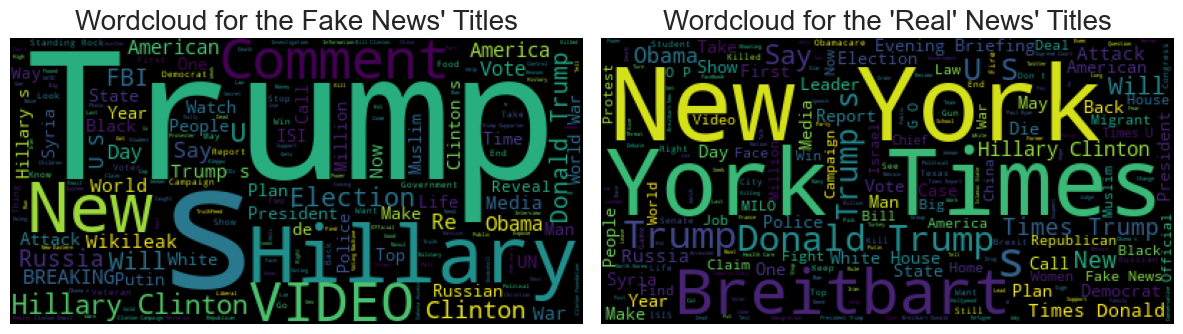

In [51]:
text_fake = ' '.join(df.loc[df.label == 1]['title'])
text_real = ' '.join(df.loc[df.label == 0]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Titles",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Titles",fontsize=20)

plt.tight_layout()
plt.show()

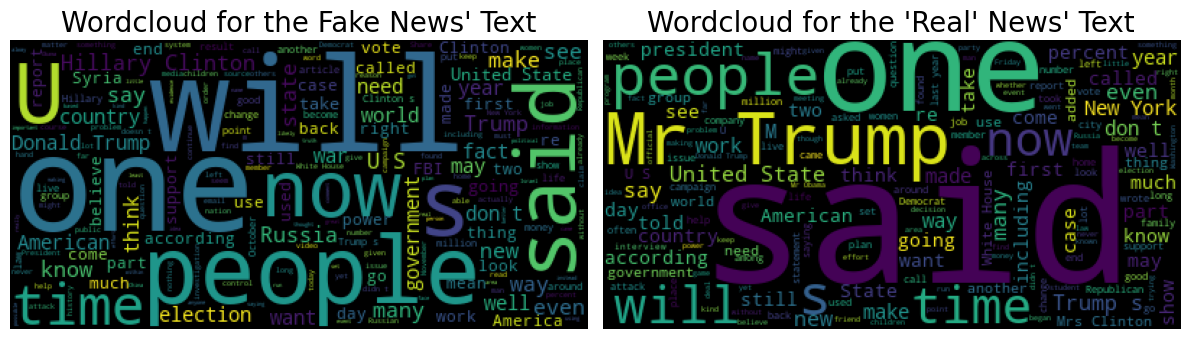

In [26]:
text_fake = ' '.join(df.loc[df.label == 1]['text'])
text_real = ' '.join(df.loc[df.label == 0]['text'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Text",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Text",fontsize=20)

plt.tight_layout()
plt.show()

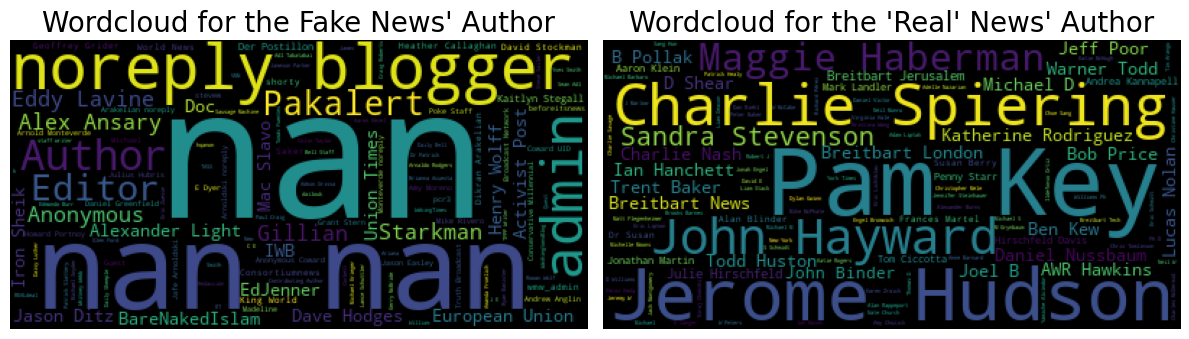

In [27]:
text_fake = ' '.join(df.loc[df.label == 1]['author'])
text_real = ' '.join(df.loc[df.label == 0]['author'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Author",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Author",fontsize=20)

plt.tight_layout()
plt.show()

In [52]:
# # Apply the approach:
# # 1. Drop rows missing both 'title' and 'text'.
# # 2. Fill missing 'title' or 'text' values with placeholders.
# # 3. Fill missing 'author' values with 'Unknown'.

# # Drop rows where both 'title' and 'text' are missing
# df = df.dropna(subset=['title', 'text'], how='all')

# # Fill missing 'title' and 'text' with placeholders
# # Fill missing 'author' values with "Unknown"
# df.fillna({'title': "Missing Title", 'text': "Missing Text", 'author': "Unknown"}, inplace=True)

# # Verify if there are any remaining missing values
df.isnull().sum()


title                       0
author                      0
text                        0
label                       0
title_token_count           0
author_token_count          0
text_token_count            0
combined_features           0
combined_features_author    0
combined_features_title     0
dtype: int64

In [ ]:
# import nltk
# nltk.download('omw-1.4')

# # Download necessary NLTK data files
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Text Preprocessing

In [10]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Initialize the lemmatizer and set of stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    tokens = text.split()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(processed_tokens)

# Apply preprocessing to 'title' and 'text' columns
df['title'] = df['title'].apply(preprocess_text)
df['text'] = df['text'].apply(preprocess_text)
df['author'] = df['author'].apply(preprocess_text)

In [48]:
# def count_tokens(text):
#     # Tokenize the text into words
#     tokens = word_tokenize(text)
#     return len(tokens)

# # Apply the token count function to 'title' and 'text' columns
# df['title_token_count'] = df['title'].apply(count_tokens)
# df['text_token_count'] = df['text'].apply(count_tokens)
# df['author_token_count'] = df['author'].apply(count_tokens)

# # Correlation between title and text token counts
# correlation = df['title_token_count'].corr(df['text_token_count'])
# print(f"\nCorrelation between Title and Text Token Counts: {correlation:.2f}")

# # Correlation between title and author token counts
# correlation = df['title_token_count'].corr(df['author_token_count'])
# print(f"\nCorrelation between Title and Author Token Counts: {correlation:.2f}")

# # Correlation between text and author token counts
# correlation = df['text_token_count'].corr(df['author_token_count'])
# print(f"\nCorrelation between Text and Author Token Counts: {correlation:.2f}")

In [148]:
# Summary statistics for token counts
print("Title Token Counts Summary:")
print(df['title_token_count'].describe())

print("\nText Token Counts Summary:")
print(df['text_token_count'].describe())

print("\nAuthor Token Counts Summary:")
print(df['author_token_count'].describe())


Title Token Counts Summary:
count    20800.000000
mean         8.493558
std          3.100704
min          0.000000
25%          7.000000
50%          9.000000
75%         10.000000
max         46.000000
Name: title_token_count, dtype: float64

Text Token Counts Summary:
count    20800.000000
mean       426.883798
std        470.763255
min          0.000000
25%        152.000000
50%        316.000000
75%        590.000000
max      12445.000000
Name: text_token_count, dtype: float64

Author Token Counts Summary:
count    20800.000000
mean         2.102212
std          1.090340
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         16.000000
Name: author_token_count, dtype: float64


In [49]:
# # Define thresholds based on EDA
# TITLE_MIN_TOKEN = 2
# TITLE_MAX_TOKEN = 25  # Increased to accommodate higher max
# TEXT_MIN_TOKEN = 50
# TEXT_MAX_TOKEN = 2000  # Adjusted based on max value

# # Filter the DataFrame to remove outliers
# df = df[
#     (df['title_token_count'] >= TITLE_MIN_TOKEN) &
#     (df['title_token_count'] <= TITLE_MAX_TOKEN) &
#     (df['text_token_count'] >= TEXT_MIN_TOKEN) &
#     (df['text_token_count'] <= TEXT_MAX_TOKEN)
# ]

# print(f"Original DataFrame shape: {df.shape}")

Top 30 tokens for label 1: [('u', 20280), ('clinton', 19854), ('trump', 19710), ('people', 16839), ('one', 16294), ('state', 14901), ('would', 14450), ('hillary', 12606), ('time', 12046), ('said', 11837), ('year', 10404), ('new', 10330), ('like', 10295), ('american', 10021), ('also', 9903), ('election', 9417), ('world', 9059), ('even', 8790), ('government', 8606), ('war', 8349), ('president', 8104), ('many', 7928), ('country', 7612), ('email', 7583), ('could', 7407), ('get', 7215), ('de', 6995), ('day', 6951), ('right', 6941), ('say', 6787)]
Top 30 tokens for label 0: [('mr', 69266), ('said', 68171), ('trump', 36177), ('one', 23464), ('would', 22782), ('state', 22541), ('year', 21583), ('people', 20026), ('new', 19661), ('time', 17945), ('president', 17288), ('like', 16345), ('also', 15527), ('american', 12055), ('could', 11890), ('two', 11409), ('many', 11264), ('first', 11001), ('last', 10908), ('day', 10637), ('u', 10415), ('united', 10176), ('even', 10086), ('say', 10062), ('countr

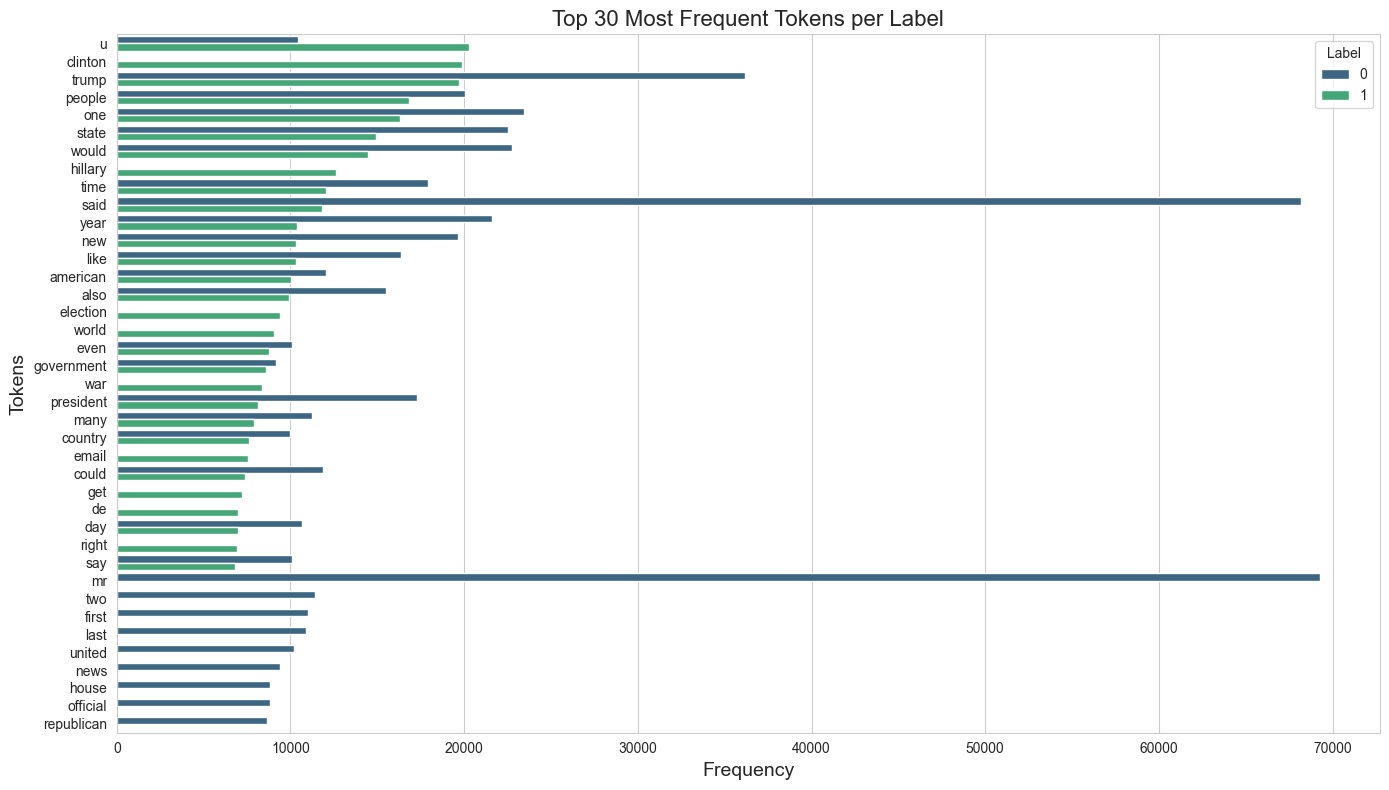

c:\Users\harsh\anaconda3\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\harsh\anaconda3\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


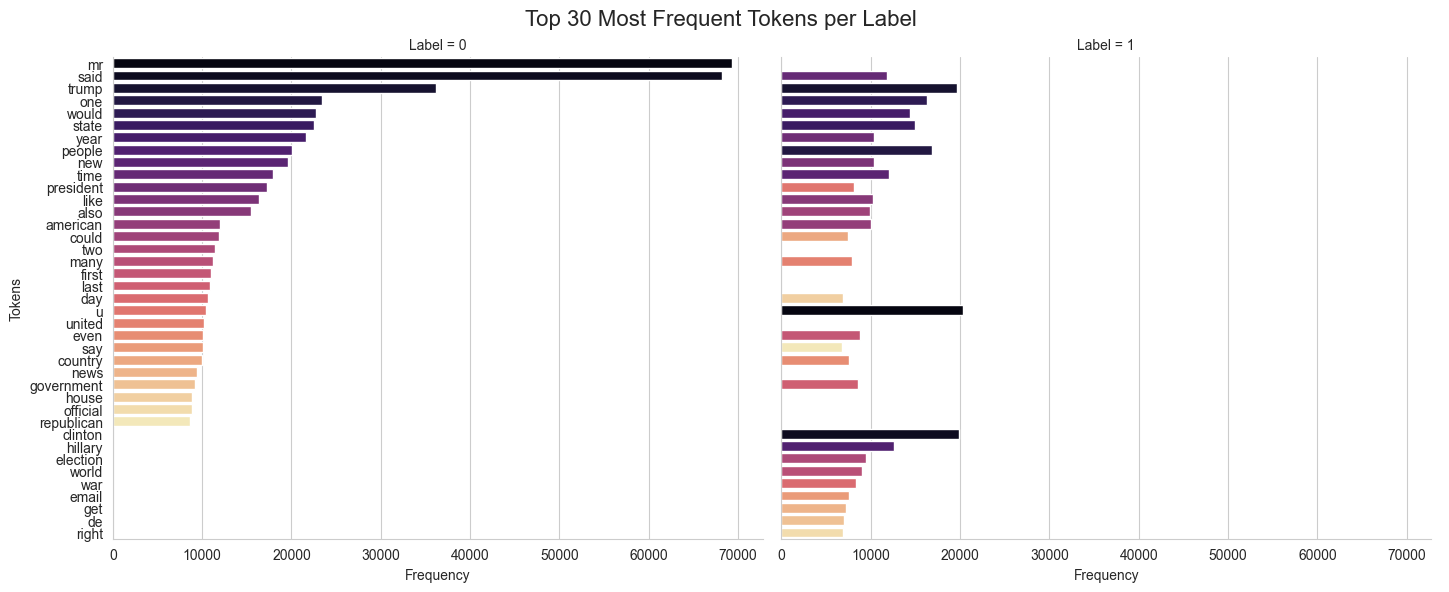

In [33]:
from collections import Counter


# Function to Get Top Tokens
def get_top_tokens(data, column, label, stop_words, n=30):
    texts = ' '.join(data[data['label'] == label][column])
    tokens = word_tokenize(texts)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    counter = Counter(tokens)
    top_n = counter.most_common(n)
    return top_n

# Identify Unique Labels
labels = df['label'].unique()

# Dictionary to Store Top Tokens per Label
top_tokens_per_label = {}

for label in labels:
    top_tokens = get_top_tokens(df, 'text', label, stop_words, n=30)
    top_tokens_per_label[label] = top_tokens
    print(f"Top 30 tokens for label {label}: {top_tokens}")

# Create a Combined DataFrame for Visualization
tokens_df = pd.DataFrame()

for label, tokens in top_tokens_per_label.items():
    temp_df = pd.DataFrame(tokens, columns=['Token', 'Frequency'])
    temp_df['Label'] = label
    tokens_df = pd.concat([tokens_df, temp_df], ignore_index=True)

# Display the Combined Tokens DataFrame
print(tokens_df)

# Plotting: Grouped Bar Chart
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
sns.barplot(x='Frequency', y='Token', hue='Label', data=tokens_df, palette='viridis')
plt.title('Top 30 Most Frequent Tokens per Label', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.legend(title='Label')
plt.tight_layout()
plt.show()

# Plotting: Facet Grid (Separate Plots per Label)
sns.set_style("whitegrid")
g = sns.FacetGrid(tokens_df, col="Label", height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x='Frequency', y='Token', palette='magma')
g.fig.suptitle('Top 30 Most Frequent Tokens per Label', fontsize=16)
g.set_axis_labels('Frequency', 'Tokens')
g.add_legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

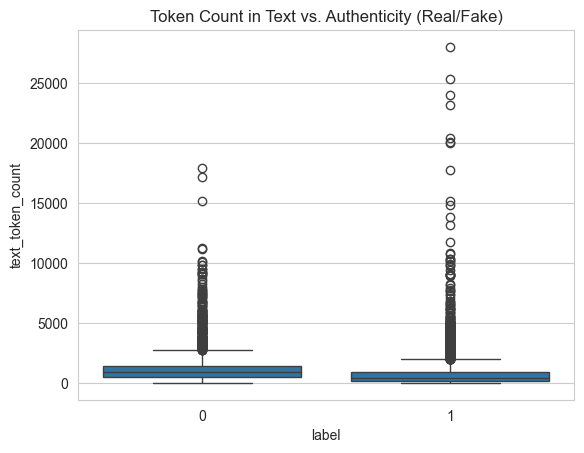

In [50]:
sns.boxplot(x='label', y='text_token_count', data=df)
plt.title("Token Count in Text vs. Authenticity (Real/Fake)")
plt.show()

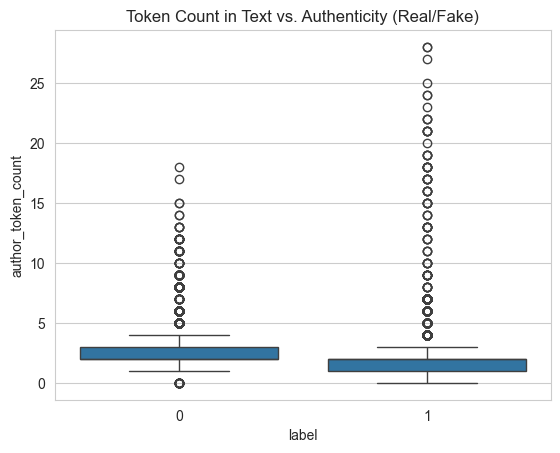

In [51]:
sns.boxplot(x='label', y='author_token_count', data=df)
plt.title("Token Count in Text vs. Authenticity (Real/Fake)")
plt.show()

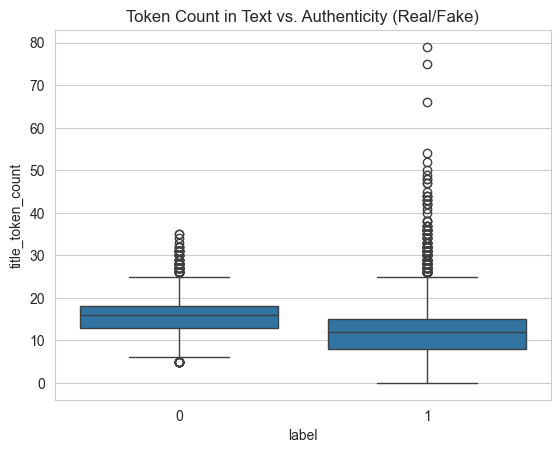

In [52]:
sns.boxplot(x='label', y='title_token_count', data=df)
plt.title("Token Count in Text vs. Authenticity (Real/Fake)")
plt.show()

In [13]:
df.head()

,title,author,text,label,title_token_count,author_token_count,text_token_count,combined_features,combined_features_author,combined_features_title,title_text
0,house dem aide didnt even see comeys letter ja...,darrell lucus,house dem aide didnt even see comeys letter ja...,1,19,2,943,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus House Dem Aide: We Didn’t Even S...,darrell lucus house dem aide didnt even see co...
1,flynn hillary clinton big woman campus breitbart,daniel j flynn,ever get feeling life circle roundabout rather...,0,11,3,822,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn Ever get the feeling your life...,daniel j flynn flynn hillary clinton big woman...
2,truth might get fired,consortiumnewscom,truth might get fired october 29 2016 tension ...,1,7,1,1454,Why the Truth Might Get You Fired Consortiumne...,Why the Truth Might Get You Fired Why the Trut...,Consortiumnews.com Why the Truth Might Get You...,consortiumnewscom truth might get fired truth ...
3,15 civilian killed single u airstrike identified,jessica purkiss,video 15 civilian killed single u airstrike id...,1,10,2,612,15 Civilians Killed In Single US Airstrike Hav...,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss Videos 15 Civilians Killed In ...,jessica purkiss 15 civilian killed single u ai...
4,iranian woman jailed fictional unpublished sto...,howard portnoy,print iranian woman sentenced six year prison ...,1,14,2,177,Iranian woman jailed for fictional unpublished...,Iranian woman jailed for fictional unpublished...,Howard Portnoy Print \nAn Iranian woman has be...,howard portnoy iranian woman jailed fictional ...


In [174]:
#list all columns names in df
print(df.columns)

Index(['title', 'author', 'text', 'label', 'title_token_count',
       'text_token_count', 'author_token_count', 'contains_hillary',
       'contains_fbi', 'contains_october',
       ...
       'entity_LOC', 'entity_PERCENT', 'entity_QUANTITY', 'entity_MONEY',
       'entity_FAC', 'entity_EVENT', 'entity_PRODUCT', 'entity_LAW',
       'entity_LANGUAGE', 'entity_WORK_OF_ART'],
      dtype='object', length=499)


In [11]:
# Token frequency filtering: Select tokens with minimum frequency of 4 for feature representation.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Option 2: Creating a copy
data = df[['title', 'text', 'author', 'label']].copy()
data['title_text'] = data['author'] + ' ' + data['title'] + ' ' + data['text']
#data['title_text'] =  data['text']
df['title_text'] = data['title_text']


In [12]:
data.head()

,title,text,author,label,title_text
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,darrell lucus,1,darrell lucus house dem aide didnt even see co...
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,daniel j flynn,0,daniel j flynn flynn hillary clinton big woman...
2,truth might get fired,truth might get fired october 29 2016 tension ...,consortiumnewscom,1,consortiumnewscom truth might get fired truth ...
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,jessica purkiss,1,jessica purkiss 15 civilian killed single u ai...
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,howard portnoy,1,howard portnoy iranian woman jailed fictional ...


## Frequency Grid Search CV

In [ ]:

# Split the data into training and test sets
X = df[['title_text', 'title_token_count', 'text_token_count', 'author_token_count']]

y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Define the pipeline
pipeline_count = Pipeline([
    ('countvec', CountVectorizer(
        ngram_range=(1, 2),     # Unigrams and Bigrams
        min_df=4,               # Minimum document frequency
        max_features=50000,     # Maximum number of features
        stop_words='english'    # Remove English stopwords
    )),
    ('feature_selection', SelectKBest(chi2, k=20000)),
    ('clf', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'clf__alpha': [0.1, 1.0],                   # MultinomialNB smoothing parameter
    'countvec__ngram_range': [(1, 1), (1, 2)],     # Unigrams or Unigrams + Bigrams
    'feature_selection__k': [20000, 30000]      # Number of top features to select
}

# Initialize the MultinomialNB classifier
nb_classifier = MultinomialNB()

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline_count,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score}')

# Evaluate the best model on the test set
best_model_count = grid_search.best_estimator_
y_pred = best_model_count.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'clf__alpha': 0.1, 'countvec__ngram_range': (1, 2), 'feature_selection__k': 20000}
Best Cross-Validation Accuracy: 0.9518028846153846
Test Set Accuracy: 0.9514423076923076
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2077
           1       0.98      0.92      0.95      2083

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



## Tf-Idf Grid Search CV

Training Set Shape: (16640, 4)
Testing Set Shape: (4160, 4)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'clf__alpha': 0.01, 'preprocessor__tfidf__max_features': 30000, 'preprocessor__tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 0.9520

Test Set Accuracy: 0.9534

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2077
           1       0.98      0.93      0.95      2083

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



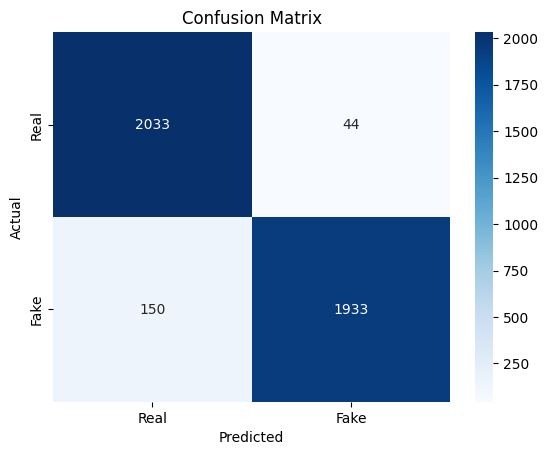

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define feature columns and target variable
X = df[['title_text', 'title_token_count', 'text_token_count', 'author_token_count']]
y = df['label']  # Replace 'label' with your actual target variable if different

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,          # 20% for testing
    random_state=42,        # Ensures reproducibility
    stratify=y              # Maintains the distribution of classes
)

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=4,
            max_features=50000,
            stop_words='english',
            norm='l2'
        ), 'title_text'),
        ('scaler', MinMaxScaler(), ['title_token_count', 'text_token_count', 'author_token_count'])
    ],
    remainder='passthrough'  # Keep other columns if any
)

# Define the complete pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(chi2, k=20000)),
    ('clf', MultinomialNB())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'preprocessor__tfidf__max_features': [20000, 30000],
    'preprocessor__tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.01, 1.0]
}

# Initialize GridSearchCV with the pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,            # Use all available cores
    verbose=1
)

# Perform Grid Search on the training data
grid_search.fit(X_train, y_train)

# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'\nTest Set Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    data['title_text'],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Define the pipeline
pipeline_tf = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=4,
        max_features=50000,
        stop_words='english',
        norm='l2'
    )),
    ('feature_selection', SelectKBest(chi2, k=20000)),
    ('clf', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'tfidf__max_features': [20000, 30000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.01, 1.0]
}

# Initialize the MultinomialNB classifier
nb_classifier = MultinomialNB()

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline_tf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Best Parameters: {'clf__alpha': 0.01, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 0.9520432692307692
Test Set Accuracy: 0.9536057692307692
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2077
           1       0.98      0.93      0.95      2083

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



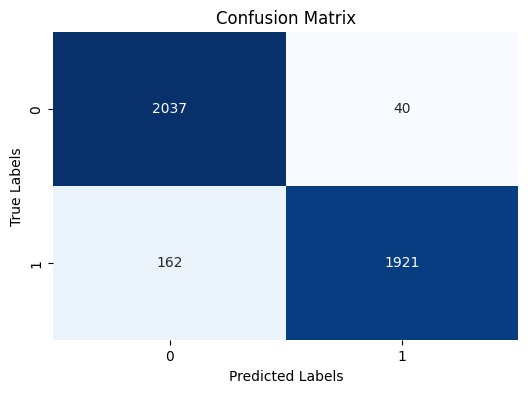

In [15]:
# Evaluate the classifier
from sklearn.metrics import classification_report, confusion_matrix

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Test Data

In [23]:
test_df = pd.read_csv('C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\IME Course\\SMA - II\\test.csv')

In [24]:
test_df.head()  

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [126]:
test_df.shape

(5200, 4)

In [25]:
# find the missing values
test_df.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [128]:
# 9. Verify Missing Values After Handling
def summarize_missing(data, dataset_name):
    print(f"\nMissing Values in {dataset_name}:")
    missing_counts = data.isnull().sum()
    missing_percent = (data.isnull().mean() * 100).round(2)
    missing_summary = pd.concat([missing_counts, missing_percent], axis=1, keys=['Missing Count', 'Missing Percentage'])
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    
    if missing_summary.empty:
        print("No missing values.\n")
    else:
        print(missing_summary.sort_values(by='Missing Percentage', ascending=False), "\n")

summarize_missing(test_df, "Entire Dataset")



Missing Values in Entire Dataset:
        Missing Count  Missing Percentage
author            503                9.67
title             122                2.35
text                7                0.13 



In [26]:
# Convert 'title' and 'text' columns to string type to handle non-string entries
test_df['title'] = test_df['title'].astype(str)
test_df['text'] = test_df['text'].astype(str)
test_df['author'] = test_df['author'].astype(str)

In [27]:
# replace admin with unknown in author
test_df['author'] = test_df['author'].replace('nan', ' ')
test_df['title'] = test_df['title'].replace('nan', ' ')
test_df['text'] = test_df['text'].replace('nan', ' ')

In [28]:
def count_tokens(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return len(tokens)

# Apply the token count function to 'title' and 'text' columns
test_df['title_token_count'] = test_df['title'].apply(count_tokens)
test_df['text_token_count'] = test_df['text'].apply(count_tokens)
test_df['author_token_count'] = test_df['author'].apply(count_tokens)

### Text

In [29]:
# Identify missing 'text' entries
missing_text = test_df['text'].isnull() | (test_df['text'].str.strip() == '')
print(f"Number of missing 'text' entries: {missing_text.sum()}")

# # Compute token counts
# test_df['title_token_count'] = test_df['title'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)
# test_df['author_token_count'] = test_df['author'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)
# test_df['text_token_count'] = test_df['text'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)

# Combine 'title' and 'author' for similarity features
test_df['combined_features'] = test_df['title'].fillna('') + ' ' + test_df['author'].fillna('')

tfidf_matrix = tfidf_vectorizer.transform(test_df['combined_features'])

# Scale numerical token counts
token_counts_scaled = scaler.transform(test_df[['title_token_count', 'author_token_count']])

# Combine TF-IDF and token counts
X_text_test = hstack([tfidf_matrix, token_counts_scaled])

# Apply weighted imputation
test_df['text_imputed'] = test_df.apply(
    lambda row: weighted_impute_text(row, df, knn_text),
    axis=1
)

# Verify imputation
print(f"Missing 'text' before imputation: {missing_text.sum()}")
missing_imputed = test_df['text_imputed'].isnull() | (test_df['text_imputed'].str.strip() == '')
print(f"Missing 'text' after imputation: {missing_imputed.sum()}")

test_df['text'] = test_df['text_imputed']
# Drop the 'text_imputed' column if it's no longer needed
test_df.drop('text_imputed', axis=1, inplace=True)



Number of missing 'text' entries: 38
Missing 'text' before imputation: 38
Missing 'text' after imputation: 0


### Author

In [30]:
# Identify missing 'author' entries in the test set
missing_author_test = test_df['author'].isnull() | (test_df['author'].str.strip() == '')
print(f"Number of missing 'author' entries in test set: {missing_author_test.sum()}")

# Feature Engineering for 'author' imputation in test data
test_df['combined_features_author'] = test_df['title'].fillna('') + ' ' + test_df['text'].fillna('')

# Vectorize combined features using the trained TF-IDF vectorizer (transform only)
tfidf_author_matrix_test = tfidf_author_vectorizer.transform(test_df['combined_features_author'])

# Scale numerical token counts using the trained scaler (transform only)
token_counts_author_scaled_test = scaler_author.transform(test_df[['title_token_count', 'text_token_count']])

# Combine TF-IDF and token counts
X_author_test = hstack([tfidf_author_matrix_test, token_counts_author_scaled_test])

# Apply weighted imputation for 'author' in test data
test_df['author_imputed'] = test_df.apply(
    lambda row: weighted_impute_author(row, knn_author, tfidf_author_vectorizer, scaler_author),
    axis=1
)

# Verify imputation in test data
print(f"Missing 'author' before imputation in test set: {missing_author_test.sum()}")
missing_imputed_author_test = test_df['author_imputed'].isnull() | (test_df['author_imputed'].str.strip() == '')
print(f"Missing 'author' after imputation in test set: {missing_imputed_author_test.sum()}")

# Optional: Replace original 'author' with imputed values in test data
test_df['author'] = test_df['author_imputed']
test_df.drop('author_imputed', axis=1, inplace=True)

Number of missing 'author' entries in test set: 503
Missing 'author' before imputation in test set: 503
Missing 'author' after imputation in test set: 14


### Title

In [39]:
# Identify missing 'title' entries in the test set
missing_title_test = test_df['title'].isnull() | (test_df['title'].str.strip() == '')
print(f"Number of missing 'title' entries in test set: {missing_title_test.sum()}")

# Feature Engineering for 'title' imputation in test data
test_df['combined_features_title'] = test_df['author'].fillna('') + ' ' + test_df['text'].fillna('')

# # Vectorize combined features using the trained TF-IDF vectorizer (transform only)
tfidf_title_matrix_test_title = tfidf_title_vectorizer.transform(test_df['combined_features_title'])

# # Scale numerical token counts using the trained scaler (transform only)
token_counts_title_scaled_test = scaler_title.transform(test_df[['author_token_count', 'text_token_count']])

# # Combine TF-IDF and token counts
X_title_test = hstack([tfidf_title_matrix_test_title, token_counts_title_scaled_test])

# Apply weighted imputation for 'title' in test data
test_df['title_imputed'] = test_df.apply(
    lambda row: weighted_impute_title(row, knn_title, tfidf_title_vectorizer, scaler_title),
    axis=1
)

# Verify imputation in test data
print(f"Missing 'title' before imputation in test set: {missing_title_test.sum()}")
missing_imputed_title_test = test_df['title_imputed'].isnull() | (test_df['title_imputed'].str.strip() == '')
print(f"Missing 'title' after imputation in test set: {missing_imputed_title_test.sum()}")

# Optional: Replace original 'title' with imputed values in test data
test_df['title'] = test_df['title_imputed']
test_df.drop('title_imputed', axis=1, inplace=True)

Number of missing 'title' entries in test set: 122
Missing 'title' before imputation in test set: 122
Missing 'title' after imputation in test set: 0


In [40]:
# Apply preprocessing to 'title' and 'text' columns
test_df['title'] = test_df['title'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)
test_df['author'] = test_df['author'].apply(preprocess_text)

In [53]:
# # Apply the approach:
# # 1. Drop rows missing both 'title' and 'text'.
# # 2. Fill missing 'title' or 'text' values with placeholders.
# # 3. Fill missing 'author' values with 'Unknown'.

# test_df.fillna({'title': "Missing Title", 'text': "Missing Text", 'author': "Unknown"}, inplace=True)

# # Verify if there are any remaining missing values
# test_df.isnull().sum()


In [22]:
# Summary statistics for token counts
print("Title Token Counts Summary:")
print(test_df['title_token_count'].describe())

print("\nText Token Counts Summary:")
print(test_df['text_token_count'].describe())

print("\nAuthor Token Counts Summary:")
print(test_df['author_token_count'].describe())


Title Token Counts Summary:
count    5200.000000
mean        8.426538
std         2.981250
min         0.000000
25%         7.000000
50%         9.000000
75%        10.000000
max        29.000000
Name: title_token_count, dtype: float64

Text Token Counts Summary:
count     5200.000000
mean       436.530577
std        479.265526
min          0.000000
25%        160.000000
50%        327.500000
75%        609.000000
max      11210.000000
Name: text_token_count, dtype: float64

Author Token Counts Summary:
count    5200.000000
mean        2.095769
std         1.108667
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        19.000000
Name: author_token_count, dtype: float64


In [41]:
test_df.head()

,id,title,author,text,title_token_count,text_token_count,author_token_count,combined_features,combined_features_author,combined_features_title
0,20800,specter trump loosens tongue purse string sili...,david streitfeld,palo alto calif year scorning political proces...,19,1588,2,"Specter of Trump Loosens Tongues, if Not Purse...","Specter of Trump Loosens Tongues, if Not Purse...","David Streitfeld PALO ALTO, Calif. — After ..."
1,20801,russian warship ready strike terrorist near al...,jakespoon,russian warship ready strike terrorist near al...,8,277,0,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,jakespoon Russian warships ready to strike ter...
2,20802,nodapl native american leader vow stay winter ...,common dream,video nodapl native american leader vow stay w...,16,824,2,#NoDAPL: Native American Leaders Vow to Stay A...,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams Videos #NoDAPL: Native American ...
3,20803,tim tebow attempt another comeback time baseba...,daniel victor,first dont succeed try different sport tim teb...,16,766,2,"Tim Tebow Will Attempt Another Comeback, This ...","Tim Tebow Will Attempt Another Comeback, This ...","Daniel Victor If at first you don’t succeed, t..."
4,20804,keiser report meme war e995,truth broadcast network,42 min ago 1 view 0 comment 0 like first time ...,8,110,3,Keiser Report: Meme Wars (E995) Truth Broadcas...,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...,Truth Broadcast Network 42 mins ago 1 Views 0 ...


In [42]:
# Token frequency filtering: Select tokens with minimum frequency of 4 for feature representation.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Option 2: Creating a copy
data = test_df[['id', 'title', 'text', 'author']].copy()
data['title_text'] = data['author'] + ' ' + data['title'] + ' ' + data['text']


In [37]:
# Combine 'title' and 'text' into 'title_text' for Consistent Vectorization
test_df['title_text'] = data['author'] + ' ' + data['title'] + ' ' + data['text']
# Select Relevant Feature Columns
X_test_final = test_df[['title_text', 'title_token_count', 'text_token_count', 'author_token_count']]

In [182]:
X_test_final.head()

,title_token_count,text_token_count,author_token_count,title_text,entity_PERSON,entity_DATE,entity_CARDINAL,entity_GPE,entity_ORG,entity_NORP,...,entity_LOC,entity_PERCENT,entity_QUANTITY,entity_MONEY,entity_FAC,entity_PRODUCT,entity_EVENT,entity_LANGUAGE,entity_LAW,entity_WORK_OF_ART
0,11,782,2,darrell lucus house dem aide didnt even see co...,1,1,1,1,1,1,...,0,0,1,1,0,0,1,0,0,0
1,7,148,1,daniel j flynn flynn hillary clinton big woman...,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
2,10,442,2,consortiumnewscom truth might get fired truth ...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,10,367,2,jessica purkiss 15 civilian killed single u ai...,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,58,3,howard portnoy iranian woman jailed fictional ...,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [85]:
data.head()

,id,title,text,author,title_text
0,20800,specter trump loosens tongue purse string sili...,palo alto calif year scorning political proces...,david streitfeld,david streitfeld specter trump loosens tongue ...
1,20801,russian warship ready strike terrorist near al...,russian warship ready strike terrorist near al...,unknown,unknown russian warship ready strike terrorist...
2,20802,nodapl native american leader vow stay winter ...,video nodapl native american leader vow stay w...,common dream,common dream nodapl native american leader vow...
3,20803,tim tebow attempt another comeback time baseba...,first dont succeed try different sport tim teb...,daniel victor,daniel victor tim tebow attempt another comeba...
4,20804,keiser report meme war e995,42 min ago 1 view 0 comment 0 like first time ...,truth broadcast network,truth broadcast network keiser report meme war...


In [43]:
# Predict labels
y_pred_count = best_model_count.predict(data['title_text'])

In [38]:
# Predict labels
y_pred = best_model.predict(X_test_final)    

In [44]:
# Create the output DataFrame
output_df = pd.DataFrame({
    'id': test_df['id'],
    'predicted_label': y_pred_count
})
# Save to CSV
#output_df.to_csv('test_predictions.csv', index=False)

In [46]:
evaluation_df = pd.read_csv('C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\IME Course\\SMA - II\\submit.csv')
# Merge predictions with evaluation labels
comparison_df = pd.merge(output_df, evaluation_df, on='id')

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(comparison_df['label'], comparison_df['predicted_label'])
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(comparison_df['label'], comparison_df['predicted_label']))

Accuracy: 0.6188461538461538
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      2339
           1       0.68      0.58      0.63      2861

    accuracy                           0.62      5200
   macro avg       0.62      0.62      0.62      5200
weighted avg       0.63      0.62      0.62      5200



In [40]:
evaluation_df = pd.read_csv('C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\IME Course\\SMA - II\\submit.csv')
# Merge predictions with evaluation labels
comparison_df = pd.merge(output_df, evaluation_df, on='id')

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(comparison_df['label'], comparison_df['predicted_label'])
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(comparison_df['label'], comparison_df['predicted_label']))

Accuracy: 0.6209615384615385
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      2339
           1       0.68      0.59      0.63      2861

    accuracy                           0.62      5200
   macro avg       0.62      0.62      0.62      5200
weighted avg       0.63      0.62      0.62      5200



In [35]:
evaluation_df = pd.read_csv('C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\IME Course\\SMA - II\\submit.csv')
# Merge predictions with evaluation labels
comparison_df = pd.merge(output_df, evaluation_df, on='id')

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(comparison_df['label'], comparison_df['predicted_label'])
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(comparison_df['label'], comparison_df['predicted_label']))

Accuracy: 0.6211538461538462
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      2339
           1       0.68      0.59      0.63      2861

    accuracy                           0.62      5200
   macro avg       0.62      0.62      0.62      5200
weighted avg       0.63      0.62      0.62      5200



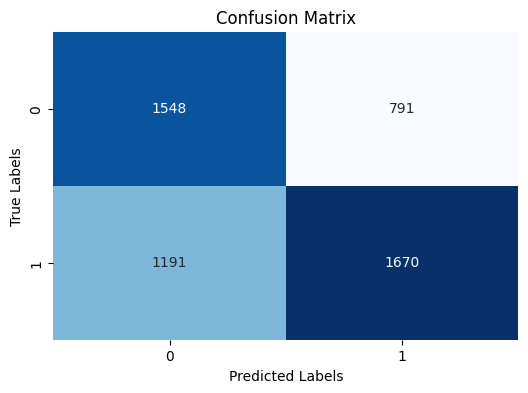

In [47]:
# Evaluate the classifier
from sklearn.metrics import classification_report, confusion_matrix

# Plot the confusion matrix
cm = confusion_matrix(comparison_df['label'], comparison_df['predicted_label'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()